# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.sql.functions import  *
from pyspark.sql import Window
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import MinMaxScaler, VectorAssembler, OneHotEncoder, StringIndexer
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, NaiveBayes, GBTClassifier
from pyspark.ml.clustering import KMeans
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 12, 9

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify data") \
    .getOrCreate()

sparkify_data = 'mini_sparkify_event_data.json'

df = spark.read.json(sparkify_data)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
df.take(5)

df.printSchema()

df.describe("length", "ts").show()

df.count()

df.select("page").dropDuplicates().sort("page").show(df.select("page").count(),False)
df.select("gender").dropDuplicates().sort("gender").show()
df.select("auth").dropDuplicates().sort("auth").show()
df.select("level").dropDuplicates().sort("level").show()
df.select("method").dropDuplicates().sort("method").show()
df.select("status").dropDuplicates().sort("status").show()

df.where(df.userId == "").show()
df.where(df.userId == "").select("page").distinct().show()
df.select("userID").distinct().count()

# columns with any NaN values, Null, or missing values
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()
df.select([count(when(col(c) == "", c)).alias(c) for c in df.columns]).show()

# drop rows with missing IDs
# df2 = df.na.drop()
df2 = df.filter(df.userId != "")
df2.select("userID").distinct().count()

df2.describe("length", "ts").show()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

+-------+-----------------+--------------------+
|summary|           length|                  ts|
+-------+-----------------+--------------------+
|  count|           228108|              286500|
|   mean|249.1171819778458|1.540956889810483...|
| stddev|99.23517921058361|1.5075439608226302E9|
|    min|  

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [4]:
# These both work in the same way, but the second breaks the rest of the code
df2 = df2.withColumn("churn", when(df.page == "Cancellation Confirmation", 1).otherwise(0))
 
#cancel_udf = udf(lambda  x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
#df2 = df2.withColumn("churn", cancel_udf(df2.page))
df2.printSchema()
df2.groupBy().sum().collect()[0]

df2.filter(df2.churn == 1).show()
df2.select(["artist","itemInSession","length", "level","page","sessionId","churn","ts"]).filter(df2.userId == 18).sort(asc('ts')).show(10)

# investigating the Downgrade too
df3 = df.withColumn("churn", when(df.page == "Downgrade", 1).otherwise(0))
df3.filter(df3.churn == 1).show()
df3.select(["artist","itemInSession","length", "level","page","sessionId","churn","ts"]).filter(df3.userId == 95).sort(asc('ts')).show(10)

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = false)

+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+-----+
|artist|     auth|firstName|gender|itemInSession| lastName|l

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [5]:
# Initializing final table

df_user = df2.select(["userId"]).distinct().sort(["userId"])

churned = df2.filter(df2.churn == 1).select('userId').distinct().sort(["userId"])

churned_array = [int(row.userId) for row in churned.collect()]

# add a new churned column to the final table
df_user = df_user.withColumn('churn', when(df_user.userId.isin(*churned_array), 1).otherwise(0))

In [6]:
# Calculate the number of songs played per hour of the day
user_window = Window \
    .partitionBy('userID') \
    .orderBy(desc('ts')) \
    .rangeBetween(Window.unboundedPreceding, 0)

cusum = df.filter((df.page == 'NextSong') | (df.page == 'Cancellation Confirmation')) \
    .select('userID', 'page', 'ts') \
    .withColumn('cancelvisit', when(df.page == "Cancellation Confirmation", 1).otherwise(0)) \
    .withColumn('period', sum('cancelvisit').over(user_window))

cusum.filter((cusum.page == 'NextSong')) \
    .groupBy('userID', 'period') \
    .agg({'period': 'count'}) \
    .agg({'count(period)': 'avg'}).show()

song_time = df2.filter(df2.page == "NextSong").withColumn("hour", hour(from_unixtime(col('ts')/1000)))

songs_in_hour = song_time.filter(song_time.page == "NextSong") \
                .groupby(song_time.hour).count() \
                .orderBy(song_time.hour.cast("float"))

songs_in_hour.take(5)

songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

+------------------+
|avg(count(period))|
+------------------+
|1013.8133333333334|
+------------------+



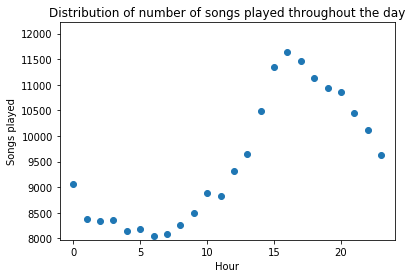

In [7]:
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24);
plt.ylim(0.99 * np.min(songs_in_hour_pd["count"]), 1.05 * np.max(songs_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played")
plt.title('Distribution of number of songs played throughout the day');

In [8]:
### Adding the average hour when the user plays a song

avg_hour_of_play = song_time.select(["userId", "hour"]) \
                    .groupBy('userID') \
                    .agg({'hour': 'avg'})

avg_hour_of_play = avg_hour_of_play.withColumnRenamed("avg(hour)", "avg_play_hour")

df_user = df_user.join(avg_hour_of_play, on = 'userId', how = 'left')

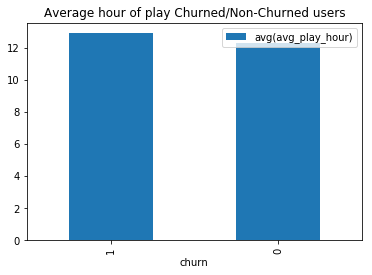

In [9]:
(df_user.groupby("churn").avg().select('churn', 'avg(avg_play_hour)')
                .toPandas()
                .set_index('churn')
                .plot(kind = 'bar', title = 'Average hour of play Churned/Non-Churned users'))

In [10]:
### Gender dummy (1: male, 0: female)
df2.cube(["gender"]).count().show()

indexer = StringIndexer(inputCol="gender", outputCol="gender_dum")
df2 = indexer.fit(df2).transform(df2)

gender_dum = df2.select(["userId", "gender_dum"]).distinct().sort("userId")

df_user = df_user.join(gender_dum, on = 'userId', how = 'left')

+------+------+
|gender| count|
+------+------+
|  null|278154|
|     F|154578|
|     M|123576|
+------+------+



In [11]:
df_user.groupby(["churn"]).avg().show()

+-----+----------+------------------+------------------+
|churn|avg(churn)|avg(avg_play_hour)|   avg(gender_dum)|
+-----+----------+------------------+------------------+
|    1|       1.0| 12.89760328761402|0.6153846153846154|
|    0|       0.0|12.280191222733785|0.5144508670520231|
+-----+----------+------------------+------------------+



In [12]:
### Days of activity

# Find minimum/maximum time stamp of each user
min_timestmp = df2.select(["userId", "ts"]).groupby("userId").min("ts")
max_timestmp = df2.select(["userId", "ts"]).groupby("userId").max("ts")

# Find days active of each user
daysActive = min_timestmp.join(max_timestmp, on="userId")
daysActive = daysActive.withColumn("days_active", 
                                   datediff(from_unixtime(col('max(ts)')/1000),
                                            from_unixtime(col('min(ts)')/1000))).select(["userId", "days_active"]) 
df_user = df_user.join(daysActive, on = 'userId', how = 'left')

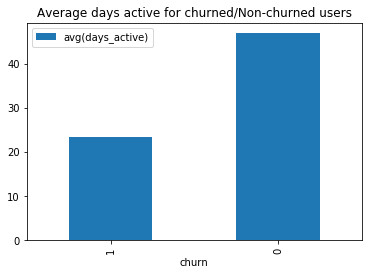

In [13]:
(df_user.groupby(["churn"]).avg().select(["churn", "avg(days_active)"])
                .toPandas()
                .set_index('churn')
                .plot(kind = 'bar', title = 'Average days active for churned/Non-churned users'))

In [14]:
### Number of sessions
n_sessions = df2.select(["userId", "sessionId"]).distinct().groupby("userId").count().sort(["userId", "count"])
n_sessions = n_sessions.withColumnRenamed("count", "n_sessions")

df_user = df_user.join(n_sessions, on = 'userId', how = 'left')

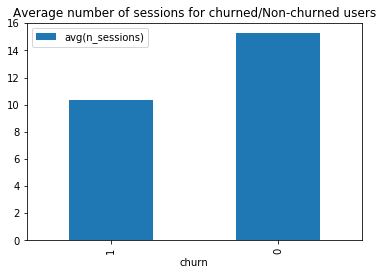

In [15]:
(df_user.groupby(["churn"]).avg().select(["churn", "avg(n_sessions)"])
                .toPandas()
                .set_index('churn')
                .plot(kind = 'bar', title = 'Average number of sessions for churned/Non-churned users'))

In [16]:
### Average numer of songs per session

avg_session_songs = df2.filter((df2.page == 'NextSong')) \
                    .groupBy('userID', 'sessionId') \
                    .agg({'song': 'count'}) \
                    .groupBy('userID') \
                    .agg({'count(song)': 'avg'})

avg_session_songs = avg_session_songs.withColumnRenamed("avg(count(song))", "avg_sess_songs")

df_user = df_user.join(avg_session_songs, on = 'userId', how = 'left')

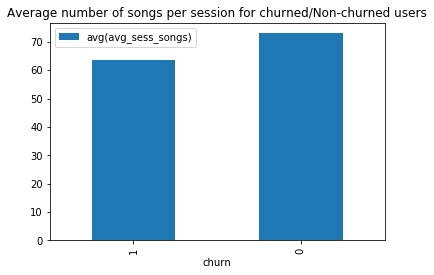

In [17]:
(df_user.groupby(["churn"]).avg().select(["churn", "avg(avg_sess_songs)"])
                .toPandas()
                .set_index('churn')
                .plot(kind = 'bar', title = 'Average number of songs per session for churned/Non-churned users'))

In [18]:
### Number of errors

errors = df2.select(["userId", "page"]).filter((df2.page == 'Error')).groupby("userId").agg({'page': 'count'})
errors = errors.withColumnRenamed("count(page)", "n_errors")

df_user = df_user.join(errors, on = 'userId', how = 'left')

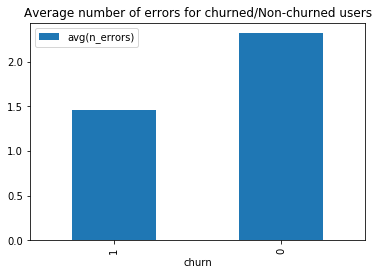

In [19]:
(df_user.groupby(["churn"]).avg().select(["churn", "avg(n_errors)"])
                .toPandas()
                .set_index('churn')
                .plot(kind = 'bar', title = 'Average number of errors for churned/Non-churned users'))

In [20]:
# Renaming churn to label
df_user = df_user.withColumnRenamed("churn", "label")

# setting missing values to zero
df_user = df_user.fillna(0)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [21]:
# Build pipeline
train, test = df_user.randomSplit([0.8, 0.2], 42)

# Vectorize the features
feature_names = ["avg_play_hour", "gender_dum", "days_active", "n_sessions", "avg_sess_songs", "n_errors"]
assembler = VectorAssembler(inputCols=feature_names, outputCol="features_vec")

# Scale each column
scalar = MinMaxScaler(inputCol="features_vec", outputCol="features")

In [22]:
def model_evaluator(model, metric, data):
    """
        args: 
            model - pipeline of a list of transformers
            metric - the metric of the evaluation (f1, accuracy, etc..)
            data - dataset used in the evaluation
        returns:
            list of [score, confusion matrix]
        Description:
            Evaluate a model's performance with our metric of choice
    """
    # generate predictions
    evaluator = MulticlassClassificationEvaluator(metricName = metric)
    predictions = model.transform(data)
    
    # calcualte score
    score = evaluator.evaluate(predictions)
    confusion_matrix = (predictions.groupby("label")
                                   .pivot("prediction")
                                   .count()
                                   .toPandas())
    return [score, confusion_matrix]


def pipe_run_f1(model, param_grid, data):
    """
        args: 
            model - pipeline of a list of transformers
            metric - the metric of the evaluation (f1, accuracy, etc..)
            param_grid - a grid of hyperparameters to be tested out
            data - dataset used in the evaluation
        returns:
            trained model
        Description:
            Trains the selected model on our data
    """
    pipeline = Pipeline(stages=[assembler, scalar, model])
    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=param_grid,
                              evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                              numFolds=3)
    out_model = crossval.fit(data)

    return out_model

In [23]:
# Logistic regression
lr = LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)

param_grid = ParamGridBuilder().build()
#    .addGrid(lr.regParam, [0.0, 0.1]) \
#    .addGrid(lr.maxIter, [10]) \
#    .build()

lr_model = pipe_run_f1(lr, param_grid, train)  # crossval.fit(train)
 
f1_lr, conf_mtx_lr = model_evaluator(lr_model, 'f1', test)
print('The F1 score for the logistic regression model is:', f1_lr)
conf_mtx_lr

The F1 score for the logistic regression model is: 0.8259686649779528


,label,0.0,1.0
0,1,5,3.0
1,0,26,NaN


In [24]:
# Random forest classifier
rf = RandomForestClassifier(numTrees = 50, featureSubsetStrategy='auto')

param_grid = ParamGridBuilder().build()
#    .addGrid(rf.maxBins, [16, 32]) \
#    .build()

rf_model = pipe_run_f1(rf, param_grid, train)

f1_rf, conf_mtx_rf = model_evaluator(rf_model, 'f1', test)
print('The F1 score for the random forest model is:', f1_rf)
conf_mtx_rf

The F1 score for the random forest model is: 0.8494265630780614


,label,0.0,1.0
0,1,3,5
1,0,24,2


In [26]:
# Gradient Boosted Tree
gb = GBTClassifier()

param_grid = ParamGridBuilder().build()

gb_model = pipe_run_f1(gb, param_grid, train)

f1_gb, conf_mtx_gb = model_evaluator(gb_model, 'f1', test)
print('The F1 score for the Gradient Boosted Tree model is:', f1_gb)
conf_mtx_gb

The F1 score for the Gradient Boosted Tree model is: 0.8298039215686274


,label,0.0,1.0
0,1,2,6
1,0,22,4


In [27]:
# Feature importance
pipeline = Pipeline(stages=[assembler, scalar, rf])
rf_model2 = pipeline.fit(train)
rf_model2.stages[-1].featureImportances

SparseVector(6, {0: 0.1396, 1: 0.0236, 2: 0.4912, 3: 0.1976, 4: 0.1134, 5: 0.0347})

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.